# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

# Imports

In [1]:
import sys

import pandas as pd

from IPython.display import HTML

sys.path.append('../')
n_jobs = 30

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

In [3]:
import utils
import model_utils
import visualization as viz

from multi_stage_classifier import MultiStageClassifier, ModelStage

constants = utils.get_constants()
seed = constants['seed']

parquet_path = constants['parquet_path']
refined_parquet_path = constants['refined_parquet_path']

## Read datasets

In [4]:
%%time

df = pd.read_parquet(parquet_path)
df_refined = pd.read_parquet(refined_parquet_path)

features_list = utils.get_features_list(df)
refined_features_list = utils.get_features_list(df_refined)

CPU times: user 50.2 s, sys: 12.5 s, total: 1min 2s
Wall time: 4.91 s


# 7+1 Classes

## Results from the original paper

              precision    recall  f1-score   support

      Benign      0.816     0.946     0.876    243322
  BruteForce      0.993     0.147     0.256      2983
        DDoS      0.999     1.000     0.999   7526151
         DoS      0.999     0.997     0.998   1792167
       Mirai      0.999     0.999     0.999    583677
       Recon      0.705     0.708     0.706     78630
    Spoofing      0.883     0.624     0.731    107798
         Web      0.972     0.038     0.073      5433

    accuracy                          0.991  10340161
   macro avg      0.921     0.682     0.705  10340161
weighted avg      0.991     0.991     0.991  10340161



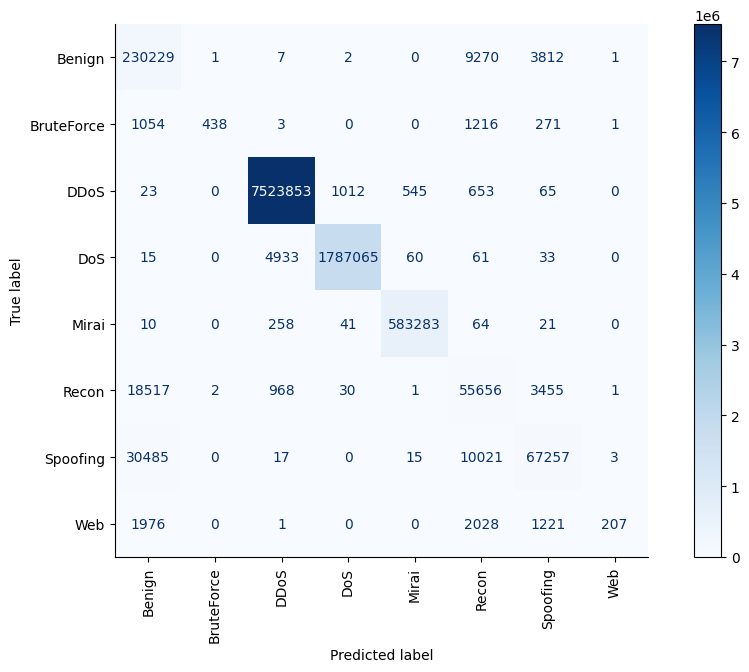

In [20]:
paper_confusion_matrix = pd.DataFrame.from_dict({
    'Benign': [230229,1,7,2,0,9270,3812,1],
    'BruteForce': [1054,438,3,0,0,1216,271,1],
    'DDoS': [23,0,7523853,1012,545,653,65,0],
    'DoS': [15,0,4933,1787065,60,61,33,0],
    'Mirai': [10,0,258,41,583283,64,21,0],
    'Recon': [18517,2,968,30,1,55656,3455,1],
    'Spoofing': [30485,0,17,0,15,10021,67257,3],
    'Web': [1976,0,1,0,0,2028,1221,207],
}, orient='index')

model_utils.show_metrics(
    paper_confusion_matrix.values,
    labels=paper_confusion_matrix.index
)

In [6]:
display(HTML(f"""
<p>
    Interesting to notice that in the paper, the authors mention that they have used a <strong>80/20 split</strong>,
    but based on the length of the dataset released and the absolute values in the Confusion Matrix, 
    we see a slightly different distribution, with the Test data having 
    <strong>{paper_confusion_matrix.sum().sum() / len(df):.2%}</strong> of the data.
</p>
"""))

## Baseline - Random Forest

In [8]:
baseline_df_split = model_utils.get_train_test_split(
    df,
    target='general_label',
    train_frac=0.80
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).


In [9]:
%%time

baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_jobs=n_jobs, random_state=seed))
])

X_train, X_test, y_train, y_test = baseline_df_split

model_utils.train_model(
    baseline_model,
    X_train,
    y_train,
    save_name='baseline_random_forest'
)

Execution time (Model fit): 0:20:43.929214
CPU times: user 6h 53min 40s, sys: 5min 19s, total: 6h 59min
Wall time: 20min 58s


In [14]:
sum(tree.tree_.node_count for tree in baseline_model['model'].estimators_)

28084252

Execution time (Predict): 0:00:58.283820
              precision    recall  f1-score   support

      Benign      0.925     0.981     0.952    219545
  BruteForce      0.995     0.566     0.721      2656
        DDoS      1.000     1.000     1.000   6797400
         DoS      1.000     1.000     1.000   1617348
       Mirai      1.000     1.000     1.000    526792
       Recon      0.911     0.846     0.877     70864
    Spoofing      0.920     0.876     0.897     97575
         Web      0.979     0.459     0.625      5136

    accuracy                          0.997   9337316
   macro avg      0.966     0.841     0.884   9337316
weighted avg      0.997     0.997     0.997   9337316

CPU times: user 6min 20s, sys: 48.6 s, total: 7min 9s
Wall time: 2min 6s


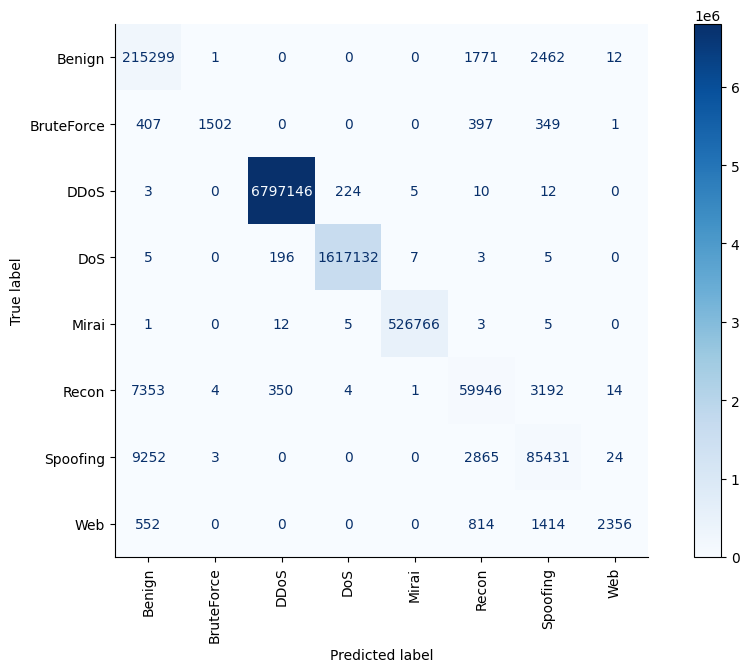

In [10]:
%%time
baseline_model = model_utils.model_load('baseline_random_forest')

X_train, X_test, y_train, y_test = baseline_df_split
model_utils.evaluate_model(baseline_model, X_test, y_test)

# Multi-Stage Model

In [7]:
multi_stage_df_split  = model_utils.get_train_test_split(
    df_refined,
    target='general_label',
    train_frac=0.80
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).


In [8]:
%%time

multi_stage_baseline_model = MultiStageClassifier(
    stages=[
        ModelStage(
            model=RandomForestClassifier(
                class_weight='balanced',
                criterion='entropy',
                max_features=10,
                n_jobs=n_jobs,
                random_state=seed
            ),
            labels={'DDoS', 'DoS', 'Mirai'}
        ),
        ModelStage(
            model=RandomForestClassifier(
                class_weight='balanced',
                criterion='entropy',
                max_features=10,
                n_jobs=n_jobs,
                random_state=seed
            ),
            labels={'Spoofing', 'Recon', 'Web', 'BruteForce'}
        ),
    ]
)

X_train, X_test, y_train, y_test = multi_stage_df_split

model_utils.train_model(
    multi_stage_baseline_model,
    X_train,
    y_train,
    save_name='multi_stage_baseline_model'
)

Execution time (Model fit): 0:23:18.646999
CPU times: user 8h 15min, sys: 4min 26s, total: 8h 19min 26s
Wall time: 23min 27s


MultiStageClassifier(stages=[ModelStage(model=RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=10, n_jobs=30, random_state=6958), labels={'DDoS', 'DoS', 'Mirai'}),
                             ModelStage(model=RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=10, n_jobs=30, random_state=6958), labels={'Spoofing', 'Recon', 'BruteForce', 'Web'})])

Execution time (Predict): 0:00:20.460678
              precision    recall  f1-score   support

      Benign      0.927     0.982     0.954    219545
  BruteForce      0.984     0.615     0.757      2656
        DDoS      1.000     1.000     1.000   6797400
         DoS      1.000     1.000     1.000   1617348
       Mirai      1.000     1.000     1.000    526792
       Recon      0.917     0.861     0.888     70864
    Spoofing      0.934     0.881     0.907     97575
         Web      0.976     0.580     0.728      5136

    accuracy                          0.997   9337316
   macro avg      0.967     0.865     0.904   9337316
weighted avg      0.997     0.997     0.997   9337316

CPU times: user 4min 24s, sys: 22.8 s, total: 4min 46s
Wall time: 1min 27s


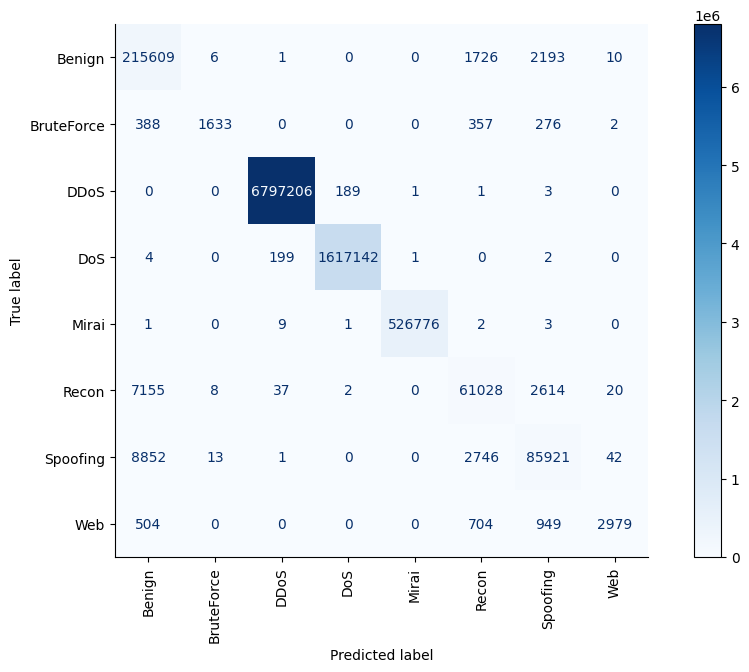

In [9]:
%%time
multi_stage_baseline_model = model_utils.model_load('multi_stage_baseline_model')

X_train, X_test, y_train, y_test = multi_stage_df_split
model_utils.evaluate_model(multi_stage_baseline_model, X_test, y_test)

In [18]:
sum(tree.tree_.node_count for tree in multi_stage_baseline_model.stages[0].model.estimators_)

868432

In [19]:
sum(tree.tree_.node_count for tree in multi_stage_baseline_model.stages[1].model.estimators_)

17578014